**Object Detetction with YOLO (You Only Look Once)**

This notebook uses pre-trained yolo for object detection and presents the results like Average Precision, Average Recall, and IoU.

Models used are:
*   yolov5l
*   yolov5m
*   yolov5s
*   yolov5n

In [ ]:
# Installing the required libraries for COCO dataset processing and YOLO model:
!pip install pycocotools
!pip install ultralytics --upgrade

In [ ]:
# Unzipping the tiny coco dataset for futher processing in the code:
!unzip /content/tiny_coco.zip -d /content/tiny_coco

Archive:  /content/tiny_coco.zip
replace /content/tiny_coco/tiny_coco/annotations/captions_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#Importing the necessary libraries:
from ultralytics import YOLO

import os
import json
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

from tabulate import tabulate

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

**YOLOv5 Block**

This block does the following:
1. Processes all the validation images and runs YOLO on each of them.
2. Outputs the predictions in annotated image format and JSON format.

In [ ]:
# Folder to save results, if the folder doesn't exist create it:
output_dir = '/content/yolo_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Folder where the test images exist --- validation folder of the coco tiny dataset:
test_images_dir = '/content/tiny_coco/tiny_coco/val2017'
test_images = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith(('.jpg', '.png'))]


model = YOLO('yolov5s.pt')                         # Initializing the YOLO model

# Running YOLO inference:
results_list = []

for img_path in test_images:
    results = model(img_path)                             # Performing inference

    # Extracting predictions: Class index, Class name, Confidence score, and
    # Bounding box [x1, y1, x2, y2]
    detections = results[0].boxes
    predictions = []
    for box in detections:
        pred = {
            'class': int(box.cls),
            'class_name': model.names[int(box.cls)],
            'confidence': float(box.conf),
            'bbox': [float(coord) for coord in box.xyxy[0].tolist()]
        }
        predictions.append(pred)

    results_list.append({
        'image_path': img_path,
        'predictions': predictions
    })

# Saveing the images and the JSON file in the output folder:
    image = cv2.imread(img_path)
    for box in predictions:
        x1, y1, x2, y2 = map(int, box['bbox'])
        label = f"{box['class_name']} ({box['confidence']:.2f})"
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    output_image_path = os.path.join(output_dir, os.path.basename(img_path))
    cv2.imwrite(output_image_path, image)

output_json_path = os.path.join(output_dir, 'yolo_predictions.json')
with open(output_json_path, 'w') as json_file:
    json.dump(results_list, json_file, indent=4)

print(f"Results saved to {output_dir}")


**Evaluation of Yolo**

1. This block assesses how well YOLO's predictions match the ground truth in terms of:
*   Precision
*   Recall
*   Localization (IoU)








In [ ]:
# Path to YOLO predictions & ground truth COCO annotations:
yolo_predictions_path = '/content/yolo_results/yolo_predictions.json'
coco_annotations_path = '/content/tiny_coco/tiny_coco/annotations/instances_val2017.json'

# Converting YOLO predictions to COCO format:
def yolo_to_coco_format(yolo_predictions, class_name_to_id):
    coco_results = []
    for item in yolo_predictions:
        image_id = int(item['image_path'].split('/')[-1].split('.')[0])
        for pred in item['predictions']:
            coco_results.append({
                'image_id': image_id,
                'category_id': class_name_to_id[pred['class_name']],
                'bbox': [
                    pred['bbox'][0],  # Bbox x_min
                    pred['bbox'][1],  # Bbox y_min
                    pred['bbox'][2] - pred['bbox'][0],  # Bbox width
                    pred['bbox'][3] - pred['bbox'][1]   # Bbox height
                ],
                'score': pred['confidence']
            })
    return coco_results

# Loading YOLO predictions & COCO annotations:
with open(yolo_predictions_path, 'r') as f:
    yolo_predictions = json.load(f)

coco_gt = COCO(coco_annotations_path)

# Get category mapping from COCO dataset
categories = coco_gt.loadCats(coco_gt.getCatIds())
class_name_to_id = {cat['name']: cat['id'] for cat in categories}

# Calling function to convert YOLO predictions to COCO format:
coco_results = yolo_to_coco_format(yolo_predictions, class_name_to_id)

# Saving the predictions in COCO format and loading:
coco_results_path = '/content/yolo_results/coco_results.json'
with open(coco_results_path, 'w') as f:
    json.dump(coco_results, f, indent=4)

coco_dt = coco_gt.loadRes(coco_results_path)

coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')   # Initializing COCOeval

# Evaluating:
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.457
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.567
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.638
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.334
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

**Plots:**

Plotting the Average Precision and Average Recall for different values of IoU:

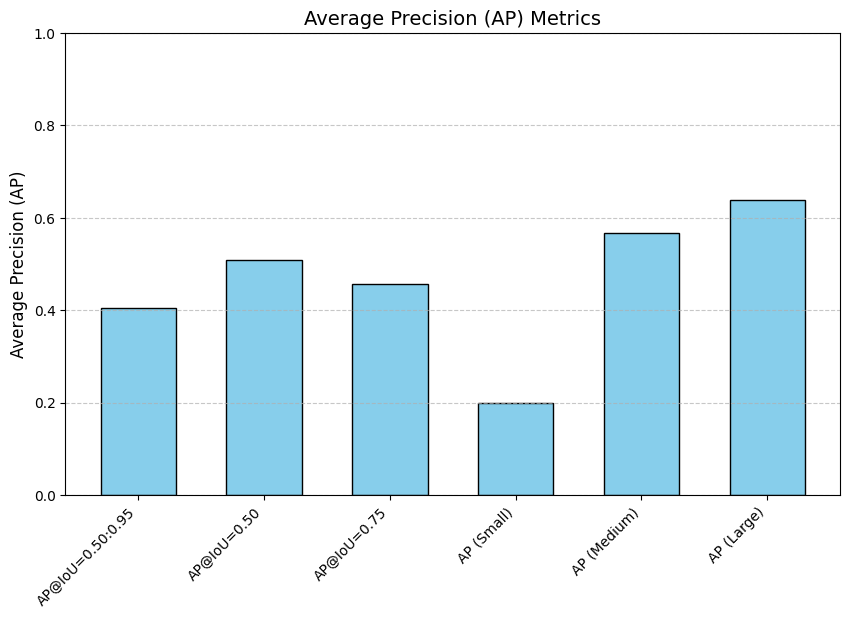

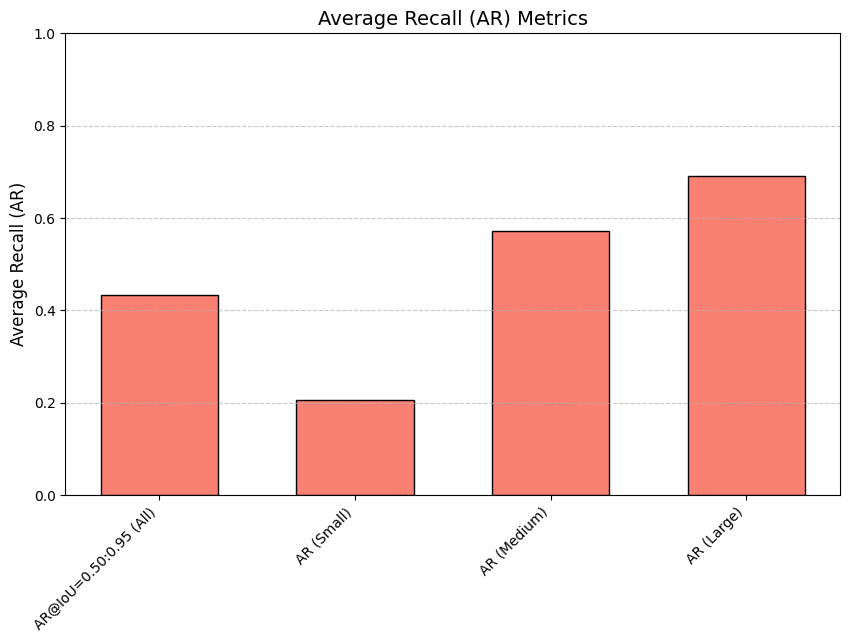

In [ ]:
# Precision:
ap_values = [0.404, 0.508, 0.457, 0.199, 0.567, 0.638]
ap_labels = ['AP@IoU=0.50:0.95', 'AP@IoU=0.50', 'AP@IoU=0.75',
             'AP (Small)', 'AP (Medium)', 'AP (Large)']

# Recall:
ar_values = [0.434, 0.205, 0.571, 0.691]
ar_labels = ['AR@IoU=0.50:0.95 (All)', 'AR (Small)', 'AR (Medium)', 'AR (Large)']

# Plotting Average Precision (AP)
plt.figure(figsize=(10, 6))
plt.bar(ap_labels, ap_values, color='skyblue', edgecolor='black', width=0.6)
plt.ylabel('Average Precision (AP)', fontsize=12)
plt.title('Average Precision (AP) Metrics', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plotting Average Recall (AR)
plt.figure(figsize=(10, 6))
plt.bar(ar_labels, ar_values, color='salmon', edgecolor='black', width=0.6)
plt.ylabel('Average Recall (AR)', fontsize=12)
plt.title('Average Recall (AR) Metrics', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Results:**

1. This block of code prints the IoU for a few images
2. This also draws the actual and predicted Bboxes on the Images

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


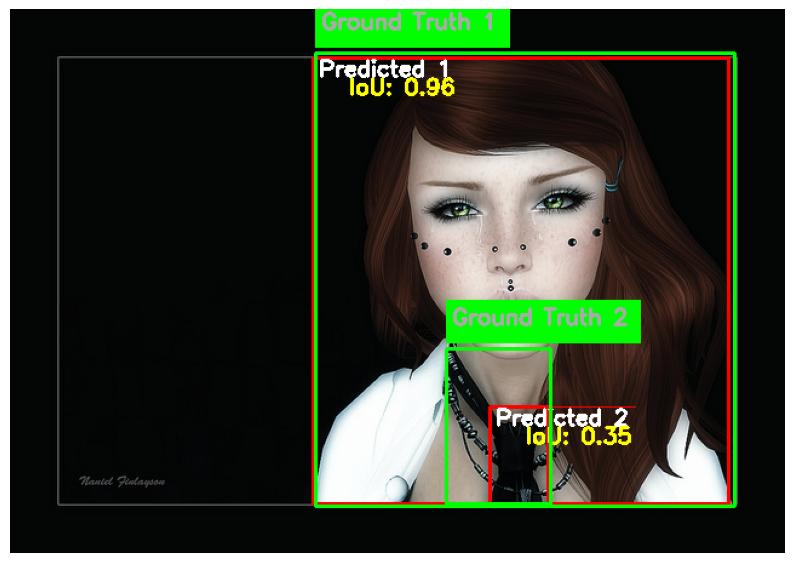

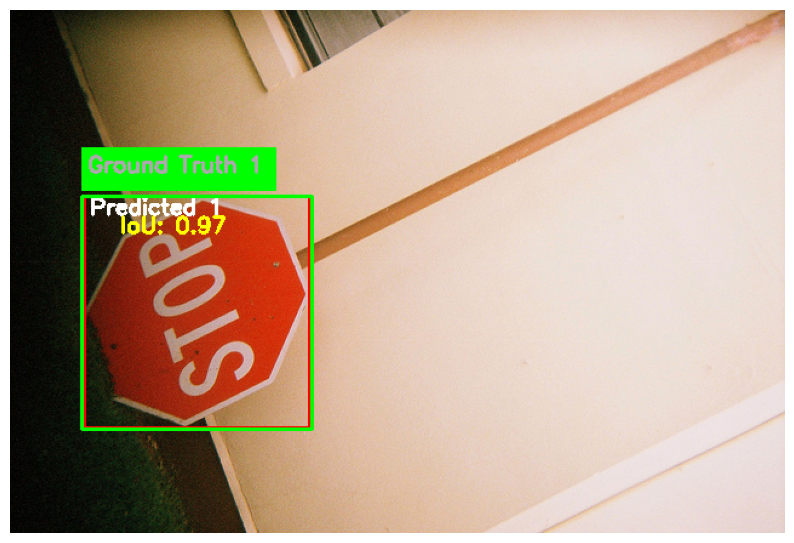

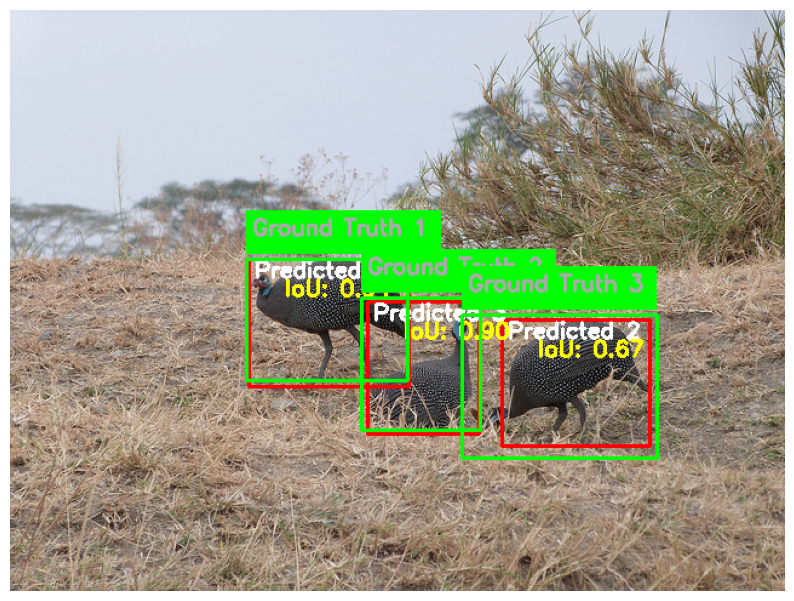

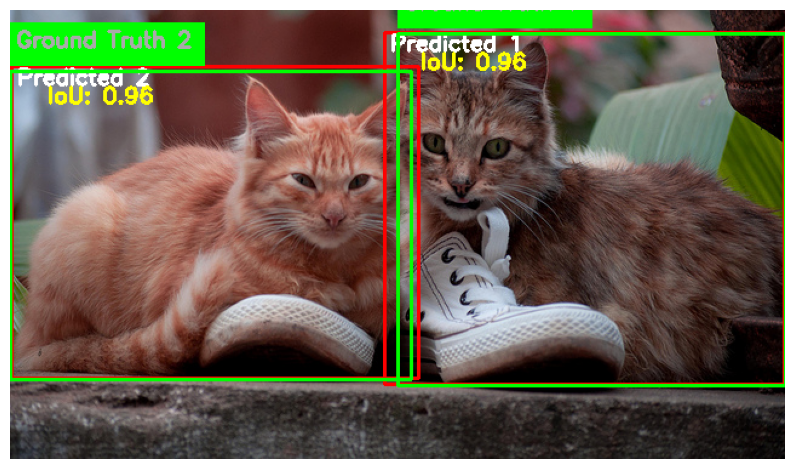

In [ ]:
def draw_boxes(image, yolo_bboxes, gt_bboxes, ious):

    # Drawing predicted boxes and IoUs:
    for idx, yolo_bbox in enumerate(yolo_bboxes):
        x, y, w, h = yolo_bbox
        yolo_start = (int(x), int(y))
        yolo_end = (int(x + w), int(y + h))
        cv2.rectangle(image, yolo_start, yolo_end, color=(255, 0, 0), thickness=2)

        cv2.rectangle(image, (yolo_start[0], yolo_start[1]), (yolo_start[0] + 120, yolo_start[1]),
                      color=(255, 0, 0), thickness=-1)
        cv2.putText(image, f'Predicted {idx+1}', (yolo_start[0] + 5, yolo_start[1] + 15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        iou = ious[idx]
        cv2.putText(image, f'IoU: {iou:.2f}', (yolo_start[0] + 30, yolo_start[1] + 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    # Drawing ground truth boxes:
    for idx, gt_bbox in enumerate(gt_bboxes):
        x, y, w, h = gt_bbox
        gt_start = (int(x), int(y))
        gt_end = (int(x + w), int(y + h))
        cv2.rectangle(image, gt_start, gt_end, color=(0, 255, 0), thickness=2)

        cv2.rectangle(image, (gt_start[0], gt_start[1] - 40), (gt_start[0] + 160, gt_start[1] - 5),
                      color=(0, 255, 0), thickness=-1)
        cv2.putText(image, f'Ground Truth {idx+1}', (gt_start[0] + 5, gt_start[1] - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (170, 170, 170), 2)

    # Displaying the Image:
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def calculate_iou(box1, box2):
    # Converting to [x1, y1, x2, y2] format:
    x1_1, y1_1, w1, h1 = box1
    x1_2, y1_2 = x1_1 + w1, y1_1 + h1

    x2_1, y2_1, w2, h2 = box2
    x2_2, y2_2 = x2_1 + w2, y2_1 + h2

    # Calculating intersection coordinates:
    x_inter1 = max(x1_1, x2_1)
    y_inter1 = max(y1_1, y2_1)
    x_inter2 = min(x1_2, x2_2)
    y_inter2 = min(y1_2, y2_2)

    # Computing intersection area:
    inter_width = max(0, x_inter2 - x_inter1)
    inter_height = max(0, y_inter2 - y_inter1)
    intersection = inter_width * inter_height

    # Computing union area:
    box1_area = w1 * h1
    box2_area = w2 * h2
    union = box1_area + box2_area - intersection

    # Computing IoU
    if union == 0:
        return 0.0
    iou = intersection / union
    return iou


def process_image(image_id, yolo_result_path, ground_truth_path, coco_gt):
    # Loading YOLO predictions & ground truth annotations:
    with open(yolo_result_path, 'r') as f:
        yolo_predictions = json.load(f)

    with open(ground_truth_path, 'r') as f:
        ground_truth_data = json.load(f)

    # Finding the prediction & ground truth bounding boxes:
    yolo_bboxes = []
    for pred in yolo_predictions:
        if pred['image_id'] == image_id:
            yolo_bboxes.append(pred['bbox'])

    gt_bboxes = []
    for ann in ground_truth_data['annotations']:
        if ann['image_id'] == image_id:
            gt_bboxes.append(ann['bbox'])

    # Calculating IoU:
    ious = []
    for yolo_bbox in yolo_bboxes:
        iou_list = []
        for gt_bbox in gt_bboxes:
            iou = calculate_iou(yolo_bbox, gt_bbox)
            iou_list.append(iou)
        max_iou = max(iou_list) if iou_list else 0.0
        ious.append(max_iou)

    # Loading the Image to draw the Bbox:
    image_info = coco_gt.loadImgs(image_id)[0]
    image_path = f"/content/tiny_coco/tiny_coco/val2017/{image_info['file_name']}"
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    draw_boxes(image, yolo_bboxes, gt_bboxes, ious) # Draw Bbox

# Defining paths and initializing the COCO API
yolo_result_path = '/content/yolo_results/coco_results.json'
ground_truth_path = '/content/tiny_coco/tiny_coco/annotations/instances_val2017.json'
coco_gt = COCO(ground_truth_path)

image_ids = [85329, 297343, 41888, 555705]
for image_id in image_ids:
    process_image(image_id, yolo_result_path, ground_truth_path, coco_gt)


**Results (Continued):**

1. This block of code makes a table of all the classes detected in each image.

In [ ]:
def display_combined_class_table(yolo_predictions, gt_annotations, coco_gt, image_ids):
    combined_data = []

    for image_id in image_ids:
        # Extract YOLO predicted & ground truth classes and then convert class IDs to class names:
        yolo_classes = [pred['category_id'] for pred in yolo_predictions if pred['image_id'] == image_id]
        gt_classes = [ann['category_id'] for ann in gt_annotations if ann['image_id'] == image_id]

        yolo_class_names = [coco_gt.loadCats([cat_id])[0]['name'] for cat_id in yolo_classes]
        gt_class_names = [coco_gt.loadCats([cat_id])[0]['name'] for cat_id in gt_classes]

        # If the length of detected objects is not same as annotated data,
        # we padd with 'N/A':
        max_len = max(len(yolo_class_names), len(gt_class_names))
        yolo_class_names += ['N/A'] * (max_len - len(yolo_class_names))
        gt_class_names += ['N/A'] * (max_len - len(gt_class_names))

        # Appending rows for each prediction/ground truth pair:
        for yolo, gt in zip(yolo_class_names, gt_class_names):
            combined_data.append({'Image ID': image_id, 'Predicted Class': yolo, 'Ground Truth Class': gt})

    print(tabulate(combined_data, headers='keys', tablefmt='grid'))

display_combined_class_table(yolo_predictions, ground_truth_data['annotations'], coco_gt, image_ids)

+------------+-------------------+----------------------+
|   Image ID | Predicted Class   | Ground Truth Class   |
+============+===================+======================+
|      85329 | person            | person               |
+------------+-------------------+----------------------+
|      85329 | tie               | tie                  |
+------------+-------------------+----------------------+
|     297343 | stop sign         | stop sign            |
+------------+-------------------+----------------------+
|      41888 | bird              | bird                 |
+------------+-------------------+----------------------+
|      41888 | bird              | bird                 |
+------------+-------------------+----------------------+
|      41888 | bird              | bird                 |
+------------+-------------------+----------------------+
|     555705 | cat               | cat                  |
+------------+-------------------+----------------------+
|     555705 |

**Test:**

Testing the Yolo on another Image of a Person


0: 640x640 1 cat, 656.2ms
Speed: 4.8ms preprocess, 656.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


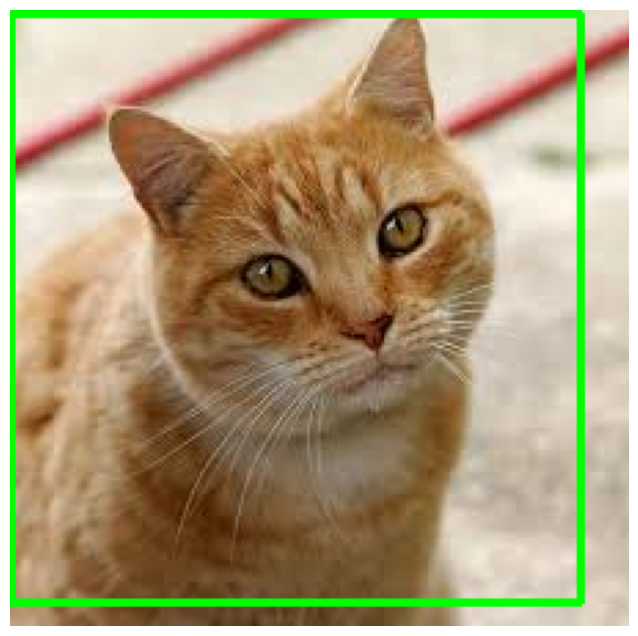

In [ ]:
def predict_and_draw(image_path):

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Predicting with Yolo:
    results = model(image_rgb)

    # Drawing the Bboxes and class labels:
    for result in results:
        for box in result.boxes.data:
            x1, y1, x2, y2, conf, cls = box
            label = f"{result.names[int(cls)]} {conf:.2f}"

            cv2.rectangle(image_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

            cv2.putText(image_rgb, label, (int(x1), int(y1) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Display the result:
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

image_path = '/content/person.jpeg'
predict_and_draw(image_path)